## <center> Import Libraries

In [135]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["font.size"] = 18

import seaborn as sns
# Customizing seaborn color palette
sns.light_palette("seagreen", as_cmap=True)
sns.set(style="darkgrid")

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from statsmodels.graphics.tsaplots import plot_pacf

import tensorflow as tf

import warnings 
warnings.filterwarnings('ignore')

## <center> Import Data

In [136]:
data = pd.read_csv(
    filepath_or_buffer ='data/GOOGLE.csv',
    parse_dates=['Date'],
    usecols=[
        'Date',
        'Open',
        'Close',
        'High',
        'Low',
        'Volume'
    ]
)
data.head()

,Date,Open,High,Low,Close,Volume
0,2008-12-01,7.140237,7.157671,6.624669,6.624918,229304279
1,2008-12-02,6.718069,6.918568,6.539987,6.852067,234463545
2,2008-12-03,6.721058,7.007733,6.608729,6.959663,237077306
3,2008-12-04,6.887434,7.060784,6.694159,6.832889,196196647
4,2008-12-05,6.750199,7.079464,6.575852,7.073238,261825722


## <center> Data Info

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3447 non-null   datetime64[ns]
 1   Open    3447 non-null   float64       
 2   High    3447 non-null   float64       
 3   Low     3447 non-null   float64       
 4   Close   3447 non-null   float64       
 5   Volume  3447 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 161.7 KB


In [138]:
data.describe()

,Open,High,Low,Close,Volume
count,3447.000000,3447.000000,3447.000000,3447.000000,3.447000e+03
mean,44.449342,44.890610,44.014931,44.463986,6.577658e+07
std,35.490494,35.884064,35.109682,35.499982,5.793460e+07
min,6.718069,6.918568,6.539987,6.624918,1.584340e+05
25%,15.523314,15.633153,15.441870,15.543489,2.723528e+07
50%,32.772999,33.181499,32.562000,32.822498,4.202600e+07
75%,57.993500,58.721251,57.511850,58.162750,8.839208e+07
max,151.863495,152.100006,149.887497,150.709000,5.952147e+08


## <center> Null Values / Duplicates

In [139]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [140]:
print(f'Duplicated data: {data.duplicated().sum()}')

Duplicated data: 0


## <center> Data Visualization

In [141]:
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA5'] = data['Close'].rolling(window=5).mean()

fig = go.Figure(
    data=[go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close']
    )]
)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.update_layout(height = 600, width = 1000, title = 'Google Stock Price')

fig.add_trace(
    go.Scatter(
        x=data['Date'], 
        y=data['MA5'], 
        opacity=0.7, 
        line=dict(color='blue', width=2), 
        name='MA 5'
    )
)
fig.add_trace(
    go.Scatter(
        x=data['Date'], 
        y=data['MA20'], 
        opacity=0.7, 
        line=dict(color='orange', width=2), 
        name='MA 20'
    )
)



fig.show()

## <center> Check correlation

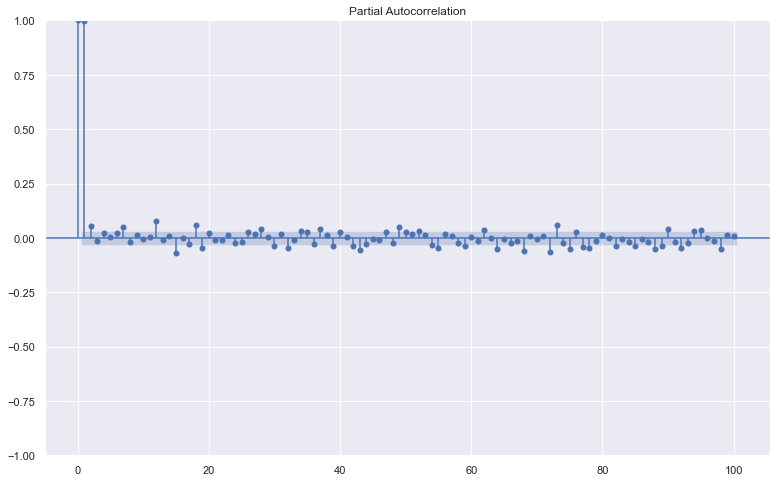

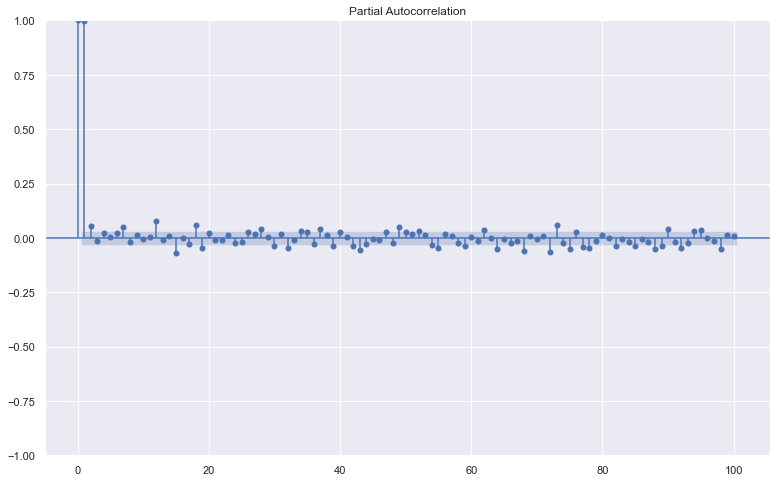

In [142]:
plot_pacf(data['Close'], lags = 100)

## <center> Dividing Data into train / test

In [143]:
split = 3000

train_data = data['Close'].iloc[:split]
test_data = data['Close'].iloc[split - 100:]

train_time = data['Date'].iloc[:split]
test_time = data['Date'].iloc[split:]

test_data.shape

(547,)

Text(0.5, 1.0, 'Train / Test divider')

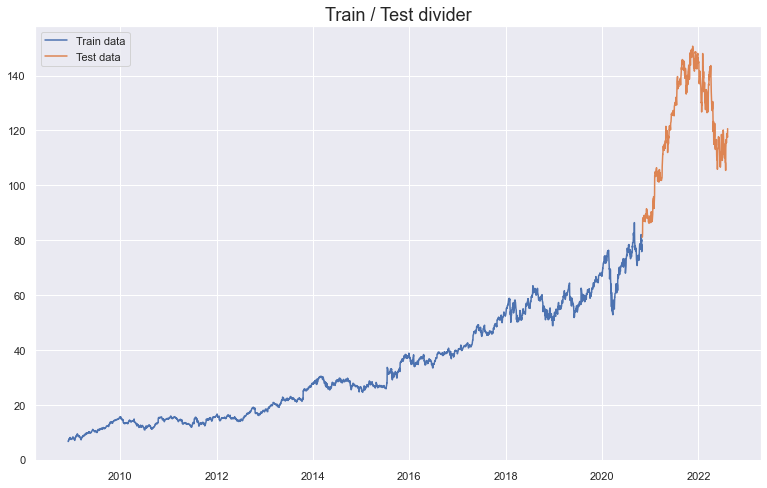

In [144]:
plt.plot(train_time, train_data, label = 'Train data')
plt.plot(test_time, test_data[100:], label = 'Test data')
plt.legend()
plt.title('Train / Test divider', fontsize = 18)


## <center> Creating a windowed dataset

In [145]:
def windowed_dataset(series, window_size=100, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

windowed_data = windowed_dataset(train_data)

In [146]:
def create_model(window_size=100):

    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[window_size,], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"), 
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss="mse", optimizer='adam')
    
    return model

model = create_model()

history = model.fit(windowed_data, epochs=100)


Epoch 1/100
      1/Unknown - 0s 316ms/step - loss: 298.8385

2022-08-11 20:59:24.237421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 1s 5ms/step - loss: 34.7452
Epoch 2/100
91/91 [==============================] - 1s 5ms/step - loss: 8.3935
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 7.1112
Epoch 4/100
91/91 [==============================] - 1s 5ms/step - loss: 5.7161
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 4.5997
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 3.7172
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 3.4268
Epoch 8/100
91/91 [==============================] - 1s 5ms/step - loss: 2.7451
Epoch 9/100
91/91 [==============================] - 1s 5ms/step - loss: 2.6832
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 2.7544
Epoch 11/100
91/91 [==============================] - 1s 4ms/step - loss: 2.4184
Epoch 12/100
91/91 [==============================] - 0s 4ms/step - loss: 2.1516
Epoch 13/100
91/91 [============================

Text(0, 0.5, 'Loss')

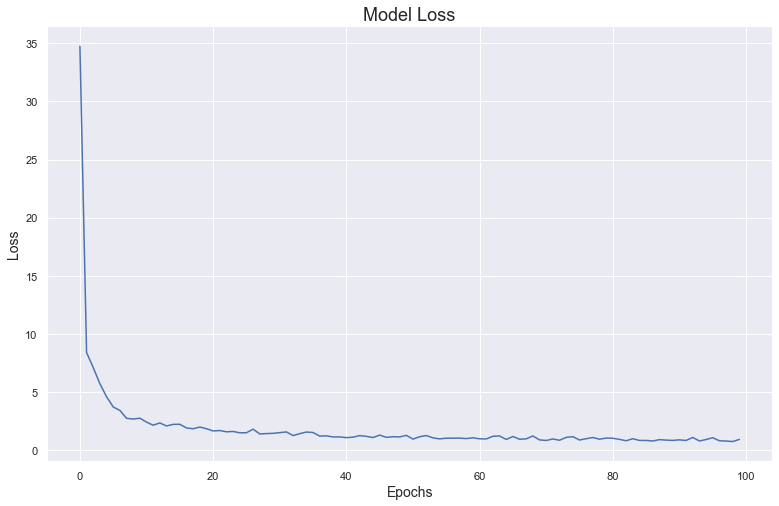

In [147]:
plt.plot(history.history['loss'], label = 'MSE')
plt.title('Model Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)


## <center> Make a prediction

In [148]:
forecast = []

for i in range(len(test_data)-100):
    forecast.append(model.predict(np.array(test_data[i:i + 100]).reshape(-1,100))[0][0])

1/1 [==============================] - 0s 10ms/step


2022-08-11 21:00:14.794521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


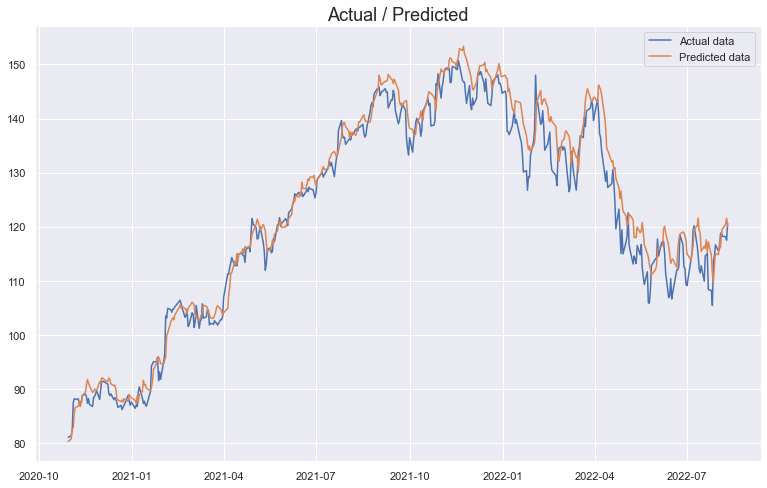

In [149]:
plt.plot(test_time, test_data[100:], label='Actual data')
plt.plot(test_time, forecast, label = 'Predicted data')
plt.title('Actual / Predicted', fontsize = 18)
plt.legend()

In [150]:
print(f"MSE: {tf.keras.metrics.mean_squared_error(test_data[100:], forecast).numpy()}")
print(f"MAE: {tf.keras.metrics.mean_absolute_error(test_data[100:], forecast).numpy()}")

MSE: 13.963736534118652
MAE: 2.801494598388672
